# **Parameters Setting**

In [68]:
### preprocess

# true for document level, false for sentence level
doc_level = False

### embedding

# choose embedding type
whether_word2vec = True
whether_POS_tag = True
whether_tfidf = True

# word2vec embedding and window size
word2vec_size = 16
word2vec_window = 9

# Pos-tagging to vec embedding size and window size
Postag2vec_size = 16
Postag2vec_window = 9

# Name Entity to vec gold label embedding size and window size
NameEntity_embedding_size = 32
NameEntity_window = 7

### model

## model architecture: 

# whether an dense after cancate(if exists, else attention layer) in the first Muti-head attention
whether_multihead_dense_encoder = True

# whether perform layer Nomalisation in model
whether_layer_normal = False

# whether to perform batch-normalisation 
whether_batch_normal = True


# whether an dense after the first Muti-head attention in encoder
whether_dense_encoder = False

# whether a hidden layer after decoder LSTM output 
whether_dense_decoder = True

# whether a hidden layer after concatenate layer
whether_concate_dense = True

# number of units in the hidden layer after concatenate layer
num_concate_dense_unit = 64

## attention and lstm dimension

# whether scale dot product or normal dot product in attention layer
whether_scale = True

# lstm dimension of encoder and decoder
lstm_hidden_dim = 32

# bi-LSTM dimension of encoder
bi_lstm_hidden_dim = 32

### hyperparameters

epoch = 800

model_learning_rate = 0.0002

weight_decay = 1e-5

beta_1_value = 0.9

# **Preprocess**

In [112]:
# this step is to define input level(sentence-level or document-level) and split sequence

import csv
# read in data
data_train = list(csv.reader(open('train.csv')))[1:100000]
data_test = list(csv.reader(open('test.csv')))[1:5000]


# record only the split sentence
sentence_token = []

# split data for document-level sequence or sentence-level input

#choose which column for the id
if doc_level:
  column_ = 1
else:
  column_ = 2

data_train_copy = []
data_test_copy = []

sentence_doc = []
name_entity_doc = []

#  the current sentence or the document id
current_id = int(data_train[0][column_])

# reform data
for i in range(len(data_train)):
  if(int(data_train[i][column_]) != current_id and i!=0):
    data_train_copy.append([sentence_doc, name_entity_doc])
    sentence_token.append(sentence_doc)
    sentence_doc = []
    name_entity_doc = []
    current_id+=1

  sentence_doc.append(data_train[i][3])
  name_entity_doc.append(data_train[i][4])

sentence_doc = []

#  the current sentence or the document id
current_id = int(data_test[0][column_])

for i in range(len(data_test)):
  if(int(data_test[i][column_]) != current_id and i!=0):
    data_test_copy.append([sentence_doc])
    sentence_token.append(sentence_doc)
    sentence_doc = []
    current_id+=1

  sentence_doc.append(data_test[i][3])

data_train = data_train_copy
data_test = data_test_copy

In [113]:
from sklearn.model_selection import train_test_split
data_train, data_val = train_test_split(data_train, test_size=0.02, random_state = 0)
print("length of train data:", len(data_train))
print("length of val data:", len(data_val))
print("length of test data:", len(data_test))

length of train data: 4144
length of val data: 85
length of test data: 200


# **Embedding**

## **Word to vector**

In [114]:
# Word2Vec based on given words. Reference: https://radimrehurek.com/gensim/models/word2vec.html
from gensim.models import Word2Vec
import numpy as np
word2vec_model = Word2Vec(np.asarray(sentence_token), size=word2vec_size,  window=word2vec_window, min_count=1, sg=1)

data_train_wv = []
data_val_wv = []
data_test_wv = []

for i in range(len(data_train)):
  train_wv = []
  for word in data_train[i][0]:
    train_wv.append(word2vec_model[word])
  data_train_wv.append(train_wv)

for i in range(len(data_val)):
  val_wv = []
  for word in data_val[i][0]:
    val_wv.append(word2vec_model[word])
  data_val_wv.append(val_wv)

for i in range(len(data_test)):
  test_wv = []
  for word in data_test[i][0]:
    test_wv.append(word2vec_model[word])
  data_test_wv.append(test_wv)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  del sys.path[0]
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:19: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:25: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).


In [115]:
print("embedding size of word2vec:", data_train_wv[0][0].shape)

embedding size of word2vec: (16,)


## **TFIDF**

In [116]:
# Reference: http://www.davidsbatista.net/blog/2018/02/28/TfidfVectorizer/
# Reference: https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html
# each word is expressed as tfidf type in one-hot style after PCA
# for example, index of "apple" is 3, vocaburary size is 1000, tfidf value of "apple" is 0.73, and thus, "apple" is expressed as 0,0,0.73,...0,0. Then it will be sent into PCA
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import decomposition
import numpy as np

def origin(data): 
  return data

# convert data into tfidf type
tfidf_model = TfidfVectorizer(use_idf=True, lowercase= True, token_pattern=False, tokenizer=origin, preprocessor=origin)
data_tfidf = tfidf_model.fit_transform(sentence_token).todense()
data_tfidf = np.asarray(data_tfidf)
tfidf_features = tfidf_model.get_feature_names()
# dictioanry for tfidf
tfidf_as_int = dict((element, i) for i, element in enumerate(tfidf_features))

# create lists to record generated tfidf
data_train_tfidf = []
data_val_tfidf = []
data_test_tfidf = []

for i in range(len(data_train)):
  train_tfidf = []
  for j in range(len(data_train[i][0])):
    tfidf_index = tfidf_as_int[data_train[i][0][j]]
    train_tfidf.append(data_tfidf[i][tfidf_index])
  data_train_tfidf.append(train_tfidf)

for i in range(len(data_test)):
  test_tfidf = []
  for j in range(len(data_test[i][0])):
    tfidf_index = tfidf_as_int[data_test[i][0][j]]
    test_tfidf.append(data_tfidf[len(data_train) + i][tfidf_index])
  data_test_tfidf.append(test_tfidf)

for i in range(len(data_val)):
  val_tfidf = []
  for j in range(len(data_val[i][0])):
    tfidf_index = tfidf_as_int[data_val[i][0][j]]
    val_tfidf.append(data_tfidf[len(data_train) + len(data_test) + i][tfidf_index])
  data_val_tfidf.append(val_tfidf)

## **POS-Tagging** 

In [117]:
# record Pos-tagging in all sentences/docs

import nltk
nltk.download('averaged_perception_tagger')
nltk.download('averaged_perceptron_tagger')

pos_tag_list = []

for i in range(len(sentence_token)):
  pos_tag = nltk.pos_tag(sentence_token[i])
  tags = []
  for tag in pos_tag:
    tags.append(tag[1])
  pos_tag_list.append(tags)

[nltk_data] Error loading averaged_perception_tagger: Package
[nltk_data]     'averaged_perception_tagger' not found in index
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [118]:
# Word2Vec Model for Pos-tagging based on generated Pos-tagging. Reference: https://radimrehurek.com/gensim/models/word2vec.html
from gensim.models import Word2Vec
import numpy as np
Postag_model = Word2Vec(np.asarray(pos_tag_list), size=Postag2vec_size,  window=Postag2vec_window, min_count=1,sg=1)

# record Pos-tag in vector for words' expression
data_train_postag = []
data_val_postag = []
data_test_postag = []

for i in range(len(data_train)):
  train_postag = []
  pos_tag = nltk.pos_tag(data_train[i][0])
  for word in pos_tag:
    train_postag.append(Postag_model[word[1]])
  data_train_postag.append(train_postag)

for i in range(len(data_val)):
  val_postag = []
  pos_tag = nltk.pos_tag(data_val[i][0])
  for word in pos_tag:
    val_postag.append(Postag_model[word[1]])
  data_val_postag.append(val_postag)

for i in range(len(data_test)):
  test_postag = []
  pos_tag = nltk.pos_tag(data_test[i][0])
  for word in pos_tag:
    test_postag.append(Postag_model[word[1]])
  data_test_postag.append(test_postag)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  from ipykernel import kernelapp as app
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:22: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:29: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).


In [119]:
print("Postag shape for train data:", data_train_postag[0][0].shape)

Postag shape for train data: (16,)


## **Embedding Vector Concat**

In [120]:
# this cell is to perform concation to be the whole embedding vectors

def embedding_concat(data_wv, data_postag, data_tfidf):
  data_concat = []
  for i in range(len(data_wv)):
    data = []
    for j in range(len(data_wv[i])):
      embedding = []
      # choose which type of embedding should be included in data
      if whether_word2vec:
        embedding += list(data_wv[i][j])
      if whether_POS_tag:
        embedding += list(data_postag[i][j])
      if whether_tfidf:
        embedding += [data_tfidf[i][j]]
      data.append(embedding)
    data_concat.append(data)

  return data_concat

embedding_train = embedding_concat(data_train_wv, data_train_postag, data_train_tfidf)
embedding_val = embedding_concat(data_val_wv, data_val_postag, data_val_tfidf)
embedding_test = embedding_concat(data_test_wv, data_test_postag, data_test_tfidf)

## **Embedding Sentence/doc as Encoder Input**

In [121]:
# Padding sentence/doc to ensure a same shape of data as encoder input of model
from tensorflow.keras import preprocessing

if doc_level:
  
  # 1920 is the longest document length , plus 1 to 1921 to satify label length
  embedding_train = preprocessing.sequence.pad_sequences(embedding_train, maxlen=1921, dtype='float', padding='post', truncating='post', value=0)
  embedding_val = preprocessing.sequence.pad_sequences(embedding_val, maxlen=1921, dtype='float', padding='post', truncating='post', value=0)

else:
  # 205 is the longest sentence length, plus 1 to 206 to satify label length
  embedding_train = preprocessing.sequence.pad_sequences(embedding_train, maxlen=206, dtype='float', padding='post', truncating='post', value=0)
  embedding_val = preprocessing.sequence.pad_sequences(embedding_val, maxlen=206, dtype='float', padding='post', truncating='post', value=0)

embedding_test = preprocessing.sequence.pad_sequences(embedding_test, maxlen=None, dtype='float', padding='post', truncating='post', value=0)
embedding_test = preprocessing.sequence.pad_sequences(embedding_test, maxlen=embedding_test.shape[1]+1, dtype='float', padding='post', truncating='post', value=0)


print("shape of Encoder Input in train set:", embedding_train.shape)
print("shape of Encoder Input in validation set:", embedding_val.shape)
print("shape of Encoder Input in test set:", embedding_test.shape)

shape of Encoder Input in train set: (4144, 206, 33)
shape of Encoder Input in validation set: (85, 206, 33)
shape of Encoder Input in test set: (200, 88, 33)


## **Name Entity as vectors(word2vec)**

In [122]:
# To ensure a better expression of Name Entity label in decoder input of the model below.
# We establish word2vec model on Name Entity label based on given data's context


labels = []
for sentence in data_train:
  # for the first decoder input, it should be a "BOS"(Begin of sequence)
  labels.append(["<BOS>"] + sentence[1])
for sentence in data_val:
  labels.append(["<BOS>"] + sentence[1])

#Word2Vec Model for Name entity label. Reference: https://radimrehurek.com/gensim/models/word2vec.html
from gensim.models import Word2Vec
import numpy as np
Nameentity_model = Word2Vec(np.asarray(labels), size=NameEntity_embedding_size,  window=NameEntity_window, min_count=1,sg=1)

train_label_vector = []
val_label_vector = []

BOS_vector = Nameentity_model["<BOS>"]

# record Name Entity gold label set in vector-type
for i in range(len(data_train)):
  train_label = []
  train_label.append(BOS_vector)
  for word in data_train[i][1]:
    train_label.append(Nameentity_model[word])
  train_label_vector.append(train_label)

for i in range(len(data_val)):
  val_label = []
  val_label.append(BOS_vector)
  for word in data_val[i][1]:
    val_label.append(Nameentity_model[word])
  val_label_vector.append(val_label)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:20: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:27: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).


## **Name Entity Vectors as Decoder Input**

In [123]:
# padding word2vec vectors as decoder input
from tensorflow.keras import preprocessing

if doc_level:
  train_decoder_input = preprocessing.sequence.pad_sequences(list(train_label_vector), maxlen = 1921, dtype='float', padding='post', truncating='post', value=0)
  val_decoder_input = preprocessing.sequence.pad_sequences(list(val_label_vector), maxlen = 1921, dtype='float', padding='post', truncating='post', value=0)

else:
  train_decoder_input = preprocessing.sequence.pad_sequences(list(train_label_vector), maxlen = 206, dtype='float', padding='post', truncating='post', value=0)
  val_decoder_input = preprocessing.sequence.pad_sequences(list(val_label_vector), maxlen = 206, dtype='float', padding='post', truncating='post', value=0)

print("shape of decoder input in training set:", train_decoder_input.shape)
print("shape of decoder input in validation set:", val_decoder_input.shape)

shape of decoder input in training set: (4144, 206, 32)
shape of decoder input in validation set: (85, 206, 32)


## **Name Entity as category(one-hot)**

In [124]:

# dictionary building for labels to convert it into category
# this step is performed since decoder output of attetion model below is one-hot type of Name entity label
from tensorflow.keras.utils import to_categorical

# collect all labels for dictionary building use
labels = []
for sentence in data_train:
  labels += sentence[1]
for sentence in data_val:
  labels += sentence[1]

# all unrepeated labels
labels = sorted(list(set((labels))))

# dictioanry for labels
labels_as_int = dict((label, i) for i, label in enumerate(labels))
int_as_labels = dict((i, label) for i, label in enumerate(labels))

train_label_category = []
val_label_category = []

# convert labels into category
for sentence in data_train:
  label = [labels_as_int[i] for i in sentence[1]]
  label = to_categorical(label, num_classes=len(labels_as_int))
  train_label_category.append(label)
for sentence in data_val:
  label = [labels_as_int[i] for i in sentence[1]]
  label = to_categorical(label, num_classes=len(labels_as_int))
  val_label_category.append(label)

print("Type number of Name entity is", len(labels_as_int))

Type number of Name entity is 3


In [125]:
# Padding sentence to ensure a same shape of data as decoder output
from tensorflow.keras import preprocessing

if doc_level:
  train_label_category = preprocessing.sequence.pad_sequences(train_label_category, maxlen=1920, dtype='float', padding='post', truncating='post', value=0)
  val_label_category = preprocessing.sequence.pad_sequences(val_label_category, maxlen=1920, dtype='float', padding='post', truncating='post', value=0)
else:
  train_label_category = preprocessing.sequence.pad_sequences(train_label_category, maxlen=205, dtype='float', padding='post', truncating='post', value=0)
  val_label_category = preprocessing.sequence.pad_sequences(val_label_category, maxlen=205, dtype='float', padding='post', truncating='post', value=0)

print("shape of one-hot style for Name Entity labels in training set, after padding:", train_label_category.shape)
print("shape of one-hot style for Name Entity labels in validation set, after padding:", val_label_category.shape)

shape of one-hot style for Name Entity labels in training set, after padding: (4144, 205, 3)
shape of one-hot style for Name Entity labels in validation set, after padding: (85, 205, 3)


## **Name Entity one-hot arrays as Decoder Output**

In [126]:
# Input&output of train model for Seq2seq model include encoder input, decoder input and decoder output
# Eecoder input is the input sentence's embedding vectors - embedding_train/embedding_val
# the final Name Entity of a sentence has a all-zeros label. And thus ,no gradient for it.

# Decoder output is to pad an array of 0 after label vector
train_decoder_output = preprocessing.sequence.pad_sequences(train_label_category, maxlen = train_label_category.shape[1] + 1, dtype='float', padding='post', truncating='post', value=0)
val_decoder_output = preprocessing.sequence.pad_sequences(val_label_category, maxlen = val_label_category.shape[1] + 1, dtype='float', padding='post', truncating='post', value=0)

print("shape of decoder output in training set:", train_decoder_output.shape)
print("shape of decoder output in validation set:", val_decoder_output.shape)

shape of decoder output in training set: (4144, 206, 3)
shape of decoder output in validation set: (85, 206, 3)


# **Seq2seq Model with Multi-head Attention**

In [84]:
# Seq2seq Reference: https://keras.io/examples/lstm_seq2seq/
# Dot product Attention layer Reference: https://www.tensorflow.org/api_docs/python/tf/keras/layers/Attention
# Muti-head Attention structure Reference: https://www.tensorflow.org/tutorials/text/transformer

from tensorflow.keras.layers import Input, Dense, Masking
from tensorflow.keras import Model, optimizers
from tensorflow.keras.layers import LSTM, Concatenate, Attention, Dropout, Bidirectional, BatchNormalization, LayerNormalization
import tensorflow as tf

## **Model Structure Design** - LayerNormal Function

In [85]:
# the function for dense with add & norm

def Layernormal(data, whether_layer_normal, whether_batch_normal):

  data = Dropout(0.2)(data)
  dense = Dense(data.get_shape().as_list()[2], activation='relu')
  if whether_layer_normal:
    data_copy = dense(data)
    layernormalization = LayerNormalization()
    data = layernormalization(data_copy+data)
    if whether_batch_normal:
      batchnormalization = BatchNormalization()
      data = batchnormalization(data)
      return data, dense, layernormalization, batchnormalization
    return data, dense, layernormalization
  else:
    data = dense(data)
    if whether_batch_normal:
      batchnormalization = BatchNormalization()
      data = batchnormalization(data)
      return data, dense, batchnormalization
    return data, dense



## **Model Structure Design** - Encoder

In [86]:

# unit number for LSTM has been declare in parameter setting

##### Model Architecture setting

#### encoder block

## encoder input
encoder_input = Input(shape = (None, embedding_train.shape[2]))

## encoder Bi-lstm 
encoder_bilstm = Bidirectional(LSTM(bi_lstm_hidden_dim, return_state=False, return_sequences=True))
encoder_bilstm_output = encoder_bilstm(encoder_input)

## encoder lstm for multi-head attention
encoder_LSTM_attention = LSTM(lstm_hidden_dim, return_state=True, return_sequences=True)
encoder_lstm_output, encoder_h, encoder_c = encoder_LSTM_attention(encoder_input)

## The first Multi-head attention in encoder

# linear layer for heads
encoder_dense_query1 = Dense(lstm_hidden_dim, activation='relu')
encoder_dense_value1 = Dense(lstm_hidden_dim, activation='relu')
encoder_dense_key1 = Dense(lstm_hidden_dim, activation='relu')

encoder_query1 = encoder_dense_query1(encoder_lstm_output)
encoder_value1 = encoder_dense_value1(encoder_lstm_output)
encoder_key1 = encoder_dense_key1(encoder_lstm_output)

# dot product attention
Mutihead_attention1 = Attention(use_scale = whether_scale)
encoder_Mutihead_attention_output1 = Mutihead_attention1([encoder_query1, encoder_value1, encoder_key1])

# linear layer after concate in Multi-head Attention
if whether_multihead_dense_encoder:
  if whether_layer_normal:
    if whether_batch_normal:
      encoder_Mutihead_attention_output1, dense_multihead_attention, LayerNormalization1, BatchNormalization1 = Layernormal(encoder_Mutihead_attention_output1, whether_layer_normal, whether_batch_normal)
    else:
      encoder_Mutihead_attention_output1, dense_multihead_attention, LayerNormalization1 = Layernormal(encoder_Mutihead_attention_output1, whether_layer_normal, whether_batch_normal)
  else:
    if whether_batch_normal:
      encoder_Mutihead_attention_output1, dense_multihead_attention, BatchNormalization1 = Layernormal(encoder_Mutihead_attention_output1, whether_layer_normal, whether_batch_normal)
    else:
      encoder_Mutihead_attention_output1, dense_multihead_attention = Layernormal(encoder_Mutihead_attention_output1, whether_layer_normal, whether_batch_normal)

# whether a layer after the first Muti-head attention in encoder
if whether_dense_encoder:
  if whether_layer_normal:
    if whether_batch_normal:
      encoder_Mutihead_attention_output1, dense_encoder_relu, LayerNormalization2, BatchNormalization2 = Layernormal(encoder_Mutihead_attention_output1, whether_layer_normal, whether_batch_normal)
    else:
      encoder_Mutihead_attention_output1, dense_encoder_relu, LayerNormalization2 = Layernormal(encoder_Mutihead_attention_output1, whether_layer_normal, whether_batch_normal)  
  else:
    if whether_batch_normal:
      encoder_Mutihead_attention_output1, dense_encoder_relu, BatchNormalization2 = Layernormal(encoder_Mutihead_attention_output1, whether_layer_normal, whether_batch_normal)
    else:
      encoder_Mutihead_attention_output1, dense_encoder_relu = Layernormal(encoder_Mutihead_attention_output1, whether_layer_normal, whether_batch_normal)  


## second Muti-head Attention Encoder part - Key and value 
encoder_dense_value2 = Dense(lstm_hidden_dim, activation='relu')
encoder_dense_key2 = Dense(lstm_hidden_dim, activation='relu')

encoder_value2 = encoder_dense_value2(encoder_Mutihead_attention_output1)
encoder_key2 = encoder_dense_key2(encoder_Mutihead_attention_output1)


## **Model Structure Design** - Decoder

In [87]:
#### decoder basic block

## decoder input
decoder_input = Input(shape = (None, train_decoder_input.shape[2]))

## decoder lstm
lstm_decoder = LSTM(lstm_hidden_dim, return_state=True, return_sequences=True)
decoder_lstm_query, decoder_h, decoder_c = lstm_decoder(decoder_input, initial_state=[encoder_h, encoder_c])

# dense after deocder LSTM
if whether_dense_decoder:
  if whether_layer_normal:
    if whether_batch_normal:
      decoder_lstm_query, dense_decoder_relu, LayerNormalization3, BatchNormalization3 = Layernormal(decoder_lstm_query, whether_layer_normal, whether_batch_normal)
    else:
      decoder_lstm_query, dense_decoder_relu, LayerNormalization3 = Layernormal(decoder_lstm_query, whether_layer_normal, whether_batch_normal)
  else:
    if whether_batch_normal:
      decoder_lstm_query, dense_decoder_relu, BatchNormalization3 = Layernormal(decoder_lstm_query, whether_layer_normal, whether_batch_normal)
    else:
      decoder_lstm_query, dense_decoder_relu = Layernormal(decoder_lstm_query, whether_layer_normal, whether_batch_normal)
   



## second Muti-head Attention Decoder part - Query in Decoder
Mutihead_attention2 = Attention(use_scale = whether_scale)
encoder_Mutihead_attention_output2 = Mutihead_attention2([decoder_lstm_query, encoder_value2, encoder_key2])

#### concat encoder Bidirectional LSTM output and Attention output
concat_layer = Concatenate(axis = 2)
concat_output = concat_layer([encoder_bilstm_output, encoder_Mutihead_attention_output2, decoder_lstm_query])

### hidden layer after concatenate layer
if whether_concate_dense:
  concat_output = Dropout(0.2)(concat_output)
  Concate_dense = Dense(num_concate_dense_unit)
  concat_output = Concate_dense(concat_output)
  if whether_batch_normal:
    BatchNormalization4 = BatchNormalization()
    concat_output = BatchNormalization4(concat_output)

#### decoder output block

dense_decoder = Dense(train_decoder_output.shape[2], activation='softmax')
decoder_output = dense_decoder(concat_output)


## **Train Model**

In [88]:
Model_train = Model([encoder_input, decoder_input], decoder_output)

#### define optimizer (Adam this is a useful optimizer based on our experience)
adam_optimizer = optimizers.Adam(lr=model_learning_rate, beta_1 = beta_1_value, decay=weight_decay)

#### model complile
Model_train.compile(loss='categorical_crossentropy', optimizer=adam_optimizer, metrics=['mse'])

## **End-to-end Learning**

In [89]:
# Tensorflow with GPU for colab Reference: https://colab.research.google.com/notebooks/gpu.ipynb#scrollTo=Y04m-jvKRDsJ
# model training/fitting (end-to-end learning)

import tensorflow as tf
try:
  with tf.device('/device:GPU:0'):
    print("GPU device performed for model fitting")
    history = Model_train.fit([embedding_train, train_decoder_input], train_decoder_output, epochs=epoch, batch_size=3000, validation_data=([embedding_val, val_decoder_input], val_decoder_output))
except:
  history = Model_train.fit([embedding_train, train_decoder_input], train_decoder_output, epochs=epoch, batch_size=3000, validation_data=([embedding_val, val_decoder_input], val_decoder_output))

Model_train.save("Model_train.hdf5")

GPU device performed for model fitting
Epoch 1/800
2/2 [==============================] - 2s 1s/step - loss: 0.5520 - mse: 0.1724 - val_loss: 0.1273 - val_mse: 0.1247
Epoch 2/800
2/2 [==============================] - 1s 271ms/step - loss: 0.4500 - mse: 0.1632 - val_loss: 0.1206 - val_mse: 0.1232
Epoch 3/800
2/2 [==============================] - 1s 259ms/step - loss: 0.3596 - mse: 0.1543 - val_loss: 0.1141 - val_mse: 0.1217
Epoch 4/800
2/2 [==============================] - 1s 276ms/step - loss: 0.2822 - mse: 0.1461 - val_loss: 0.1080 - val_mse: 0.1202
Epoch 5/800
2/2 [==============================] - 1s 275ms/step - loss: 0.2181 - mse: 0.1397 - val_loss: 0.1022 - val_mse: 0.1188
Epoch 6/800
2/2 [==============================] - 1s 275ms/step - loss: 0.1690 - mse: 0.1352 - val_loss: 0.0968 - val_mse: 0.1175
Epoch 7/800
2/2 [==============================] - 1s 270ms/step - loss: 0.1326 - mse: 0.1321 - val_loss: 0.0919 - val_mse: 0.1163
Epoch 8/800
2/2 [==============================

## **Encoder Model**

In [90]:
#### Model encoder building

Model_encoder = Model(encoder_input, [encoder_value2, encoder_key2, encoder_h, encoder_c, encoder_bilstm_output])
Model_encoder.save("Model_encoder.hdf5")

print("summary of encoder model:",Model_encoder.summary())

Model: "model_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_11 (InputLayer)           [(None, None, 33)]   0                                            
__________________________________________________________________________________________________
lstm_7 (LSTM)                   [(None, None, 32), ( 8448        input_11[0][0]                   
__________________________________________________________________________________________________
dense_18 (Dense)                (None, None, 32)     1056        lstm_7[0][0]                     
__________________________________________________________________________________________________
dense_19 (Dense)                (None, None, 32)     1056        lstm_7[0][0]                     
____________________________________________________________________________________________


## **Decoder Model**

In [91]:

#### Model decoder building

# initial states come from encoder
h_input = Input(shape=(lstm_hidden_dim,))
c_input = Input(shape=(lstm_hidden_dim,))

# Define input of Decoder Model

# decoder input
decoder_input = Input(shape = (1, train_decoder_input.shape[2]))

# encoder key and value input for Multi-head attention
value_input = Input(shape=(None, lstm_hidden_dim))
key_input = Input(shape=(None, lstm_hidden_dim))

bilstm_input = Input(shape=(1, 2*bi_lstm_hidden_dim))

# layers in train model of decoder blocks transform into decoder model
decoder_lstm_query, decoder_h, decoder_c = lstm_decoder(decoder_input, initial_state=[h_input, c_input])

if whether_dense_decoder:
  if whether_layer_normal:
    decoder_lstm_query_copy = dense_decoder_relu(decoder_lstm_query)
    decoder_lstm_query = LayerNormalization3(decoder_lstm_query_copy + decoder_lstm_query)
    if whether_batch_normal:
      decoder_lstm_query = BatchNormalization3(decoder_lstm_query)
  else:
    decoder_lstm_query = dense_decoder_relu(decoder_lstm_query)
    if whether_batch_normal:
      decoder_lstm_query = BatchNormalization3(decoder_lstm_query)

attention_output = Mutihead_attention2([decoder_lstm_query, value_input, key_input])
concat_output = concat_layer([bilstm_input, attention_output, decoder_lstm_query])

if whether_concate_dense:
  concat_output = Concate_dense(concat_output)
  if whether_batch_normal:
    concat_output = BatchNormalization4(concat_output)

decoder_output = dense_decoder(concat_output)
Model_decoder = Model([decoder_input, h_input, c_input, value_input, key_input, bilstm_input], [decoder_output, decoder_h, decoder_c])

Model_decoder.save("Model_decoder.hdf5")

print("summary of decoder model:",Model_decoder.summary())

Model: "model_6"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_15 (InputLayer)           [(None, 1, 32)]      0                                            
__________________________________________________________________________________________________
input_13 (InputLayer)           [(None, 32)]         0                                            
__________________________________________________________________________________________________
input_14 (InputLayer)           [(None, 32)]         0                                            
__________________________________________________________________________________________________
lstm_8 (LSTM)                   multiple             8320        input_15[0][0]                   
                                                                 input_13[0][0]             

# **Evaluation**

## **First Evaluation** - Visualisation of fitting process

minimum of train loss: 0.0062849391251802444
minimum of validation loss: 0.0076039680279791355
The final epoch train loss: 0.0062981401570141315
The final epoch validation loss: 0.007809330243617296
The final epoch train Mean square error: 0.1548958718776703
The final epoch validation Mean square error: 0.15187518298625946


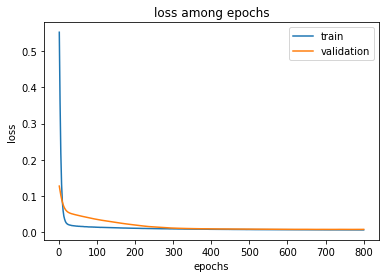

In [92]:

import matplotlib.pylab as plt
plt.plot(list(range(1,epoch+1)), history.history['loss'], label = 'train')
plt.plot(list(range(1,epoch+1)), history.history['val_loss'], label = 'validation')
plt.xlabel("epochs")
plt.ylabel('loss')
plt.legend()
plt.title("loss among epochs")
print("minimum of train loss:", min(history.history['loss']))
print("minimum of validation loss:", min(history.history['val_loss']))
print("The final epoch train loss:", history.history['loss'][-1])
print("The final epoch validation loss:", history.history['val_loss'][-1])
print("The final epoch train Mean square error:", history.history['mse'][-1])
print("The final epoch validation Mean square error:", history.history['val_mse'][-1])

## **Second Evaluation** - Validation set prediction examples

In [93]:
import numpy as np

# accuracy
true_predict = 0
false_predict = 0

# F1 score
gold_labels = []
predicted_labels = []

# predictions on validation set step by step
for i in range(len(embedding_val)):

  # data generated from encoder
  data = embedding_val[i].reshape(1, embedding_val[i].shape[0], embedding_val[i].shape[1])
  [value_out, key_out, h, c, encoder_bilstm_out] = Model_encoder.predict(data)

  # the first decoder input
  decoder_in = BOS_vector.reshape(1,1,BOS_vector.shape[0])
  predictions = []

  # encoder value and key output as decoder value and key input
  value_in = value_out
  key_in = key_out

  # Name entity set generation step by step, through decoder
  for j in range(len(data_val[i][1])):
    bilstm_in = encoder_bilstm_out[0][j].reshape(1, 1, encoder_bilstm_out[0][j].shape[0])
    [decoder_out, h, c] = Model_decoder.predict([decoder_in, h, c, value_in, key_in, bilstm_in])
    prediction = np.argmax(decoder_out)
    prediction = int_as_labels[prediction]
    predictions.append(prediction)
    if(data_val[i][1][j] == prediction):
      true_predict += 1
    else:
      false_predict += 1
    decoder_in = Nameentity_model[prediction]
    decoder_in = decoder_in.reshape(1,1,decoder_in.shape[0])
  predicted_labels += predictions
  gold_labels += data_val[i][1]
  if(i % 10 == 9):
    accuracy = (true_predict)/(true_predict + false_predict)
    print('\n',i,"/", len(embedding_val), "validation data accuracy:", accuracy)
    print("Input: ", " ".join(data_val[i][0]))
    print("Gold Name Entity:", " ".join(data_val[i][1]))
    print("Predicted Name Entity:", " ".join(predictions))
accuracy = (true_predict)/(true_predict + false_predict)
print("\nOverall accuracy (micro average f1 score):", accuracy)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:37: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).



 9 / 85 validation data accuracy: 0.9955947136563876
Input:  Subjects were assigned to a no-accountability condition ( they learned that all of their responses would be anonymous ) , a preexposure-accountability condition ( they learned of the need to justify their responses before seeing the test-takers ' PRF responses ) , and a postexposure-accountability condition ( they learned of the need to justify their responses after seeing the test-takers ' PRF responses ) .
Gold Name Entity: O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O
Predicted Name Entity: O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O

 19 / 85 validation data accuracy: 0.979253112033195
Input:  Insulin and insulin monoiodinated in tyrosine A14 , A19 , B16 and B26 can be separated using reversed-phase high-performance liquid chromatography on a number of C

## **Third Evaluation** - Classification Report

In [94]:
# Reference https://scikit-learn.org/stable/modules/generated/sklearn.metrics.classification_report.html
from sklearn.metrics import classification_report, f1_score
evaluation_metrics = classification_report(gold_labels, predicted_labels)
print(evaluation_metrics)

               precision    recall  f1-score   support

B-indications       0.30      0.10      0.15        31
I-indications       0.38      0.27      0.32        22
            O       0.98      0.99      0.98      1901

     accuracy                           0.97      1954
    macro avg       0.55      0.45      0.48      1954
 weighted avg       0.96      0.97      0.96      1954



In [95]:
# detailed F1 score
# Reference https://scikit-learn.org/stable/modules/generated/sklearn.metrics.f1_score.html

micro_f1 = f1_score(gold_labels, predicted_labels, average="micro")
macro_f1 = f1_score(gold_labels, predicted_labels, average="macro")
weighted_f1 = f1_score(gold_labels, predicted_labels, average="weighted")

print("micro average F1 score on Validation set:", micro_f1)
print("macro average F1 score on Validation set:", macro_f1)
print("weighted average F1 score on Validation set:", weighted_f1)

micro average F1 score on Validation set: 0.9692937563971341
macro average F1 score on Validation set: 0.48224073806489737
weighted average F1 score on Validation set: 0.9637625238209377


# **Test data prediction**

In [127]:
# test data prediction is similar to validation data prediction
import pandas as pd
predictions_list = []
predictions = []

# predict test data and record to csv doc
for i in range(len(embedding_test)):
    data = embedding_test[i].reshape(1, embedding_test[i].shape[0], embedding_test[i].shape[1])
    [value_out, key_out, h, c, encoder_bilstm_out] = Model_encoder.predict(data)
    decoder_in = BOS_vector.reshape(1,1,BOS_vector.shape[0])
    value_in = value_out
    key_in = key_out

    for j in range(len(data_test[i][0])):
        bilstm_in = encoder_bilstm_out[0][j].reshape(1, 1, encoder_bilstm_out[0][j].shape[0])
        [decoder_out, h, c] = Model_decoder.predict([decoder_in, h, c, value_in, key_in, bilstm_in])
        prediction = np.argmax(decoder_out)
        prediction = int_as_labels[prediction]
        predictions.append(prediction)
        decoder_in = Nameentity_model[prediction]
        decoder_in = decoder_in.reshape(1,1,decoder_in.shape[0])
    predictions_list.append(predictions)
    predictions = []

dataframe = {"Prediction": predictions_list}
dataframe = pd.DataFrame.from_dict(dataframe)
dataframe.to_csv("prediction_result.csv")

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:20: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).


# **Reference**

In [128]:
# Word2Vec based on given words. Reference: https://radimrehurek.com/gensim/models/word2vec.html
# TFIDF Reference: http://www.davidsbatista.net/blog/2018/02/28/TfidfVectorizer/
# TFIDF in vectors Reference: https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html
# Word2Vec Model for Pos-tagging based on generated Pos-tagging. Reference: https://radimrehurek.com/gensim/models/word2vec.html
# Seq2seq Reference: https://keras.io/examples/lstm_seq2seq/
# Dot product Attention layer Reference: https://www.tensorflow.org/api_docs/python/tf/keras/layers/Attention
# Muti-head Attention structure Reference: https://www.tensorflow.org/tutorials/text/transformer
# Tensorflow with GPU for colab Reference: https://colab.research.google.com/notebooks/gpu.ipynb#scrollTo=Y04m-jvKRDsJ
# Classification report Reference https://scikit-learn.org/stable/modules/generated/sklearn.metrics.classification_report.html
# F1 score Reference https://scikit-learn.org/stable/modules/generated/sklearn.metrics.f1_score.html